# Overview: Post-Processing Hydro Models - From Explosion to Spectra

In this notebook, we will learn how to post-process hydrodynamic simulation models to create synthetic spectra using TARDIS. The example used here are from a delayed detonation model for thermonuclear supernova, obtained from [Heidelberg Supernova Model Archive (HESMA, see reference within)](https://old-hesma.h-its.org/doku.php?id=data:models:ddt_2013_n100_overview).
This model is pre-parsed into the TARDIS configuration format and contains the ejecta conditions at $t = 100.22 s$ after the start of the explosion.

**The Physics Behind Time Series Modeling in TARDIS**

**Key Insight**: During the photospheric phase, supernovae undergo homologous expansion where density $\rho(t) = \rho(t_0) (\frac{t}{t_0})^{-3}$ while maintaining the same structure in velocity space. This allows us to use a single ejecta model to generate spectra at multiple epochs by adjusting:
- Time since explosion ($t_{\text{exp}}$)
- Bolometric luminosity ($L$) at given time
- Inner boundary velocity ($v_{\text{inner}}$) at given time

<div style="background-color:rgb(95, 83, 77); border-left: 4px solid #f44336; padding: 10px; margin: 10px 0;">
<strong> Note:</strong> 
For thermonuclear explosions, the time it takes from the start of explosion to homology is usually short (on the scale of tens of seconds). However, it is often longer for core collapse supernovae (on the scale of hours to days).
</div>


If the hydro model output does not provide photospheric velocity, the challenge is determining the correct $v_{\text{inner}}$ at each epoch, which should correspond to the photospheric location where optical depth $\tau \approx 2/3$.

In TARDIS, this position corresponds to the location where the dilution factor $W=0.5$, which represents that 50% of the energy escapes compares to a black body. 


**Learning Objectives**:<br>

In this notebook, you will be instructed to:
1. **Visualize and interpret** hydrodynamic model structure (density, abundance profiles)
2. **Estimate v_inner_boundary velocity** using the dilution factor $W = 0.5$ criterion
3. **Analyze spectral features** using TARDIS built-in visualization tools



# Importing the modules we need 
$\blacktriangleright$ run the cell below to import the modules you need. 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

from tardis.model import SimulationState
from tardis import run_tardis
from tardis.io.configuration.config_reader import Configuration
from tardis.workflows.util import get_tau_integ
from tardis.visualization import SDECPlotter, LIVPlotter, LineInfoWidget
from tardis.util.base import atomic_number2element_symbol, int_to_roman, element_symbol2atomic_number

from astropy import units as u
from astropy import constants as const


# Loading and Understanding the ejecta Model 

In TARDIS, the ejecta model information is processed into the `simulation_state` class, and it can be parsed directly from the config. 

$\blacktriangleright$ run the cell below to read the config into a simulation_state WITHOUT actually running TARDIS.  

See the [source code of the simulation_state](https://github.com/tardis-sn/tardis/blob/fa4c4ea98055ea3bef24d69feba26fb5f74c2ddf/tardis/model/base.py#L38) to see the available attributes and properties. 

In [9]:
CONFIG_FILE = "configs_and_data/tardis_ddt_2013_n100.yml"
config = Configuration.from_yaml(CONFIG_FILE)
simulation_state = SimulationState.from_csvy(config)


[tardis.io.model.parse_mass_fraction_configuration][WARNING]  Mass fractions have not been normalized to 1. - normalizing (parse_mass_fraction_configuration.py:164)
[tardis.model.matter.decay][INFO   ]  Decaying abundances for 863900.0352 seconds (decay.py:101)


### Visualize the Model Structure (Density and abundance profile as a function of velocity)

$\blacktriangleright$ Your task: Examine the ejecta model visually - plot the mass fractions of the elements and the density profile as a function of velocity, on the same figure.
(Plot mass fraction using the normal yaxis, and plot density using the y-axis on the right hand side.) 

---
**Useful information**

- The velocity can be accessed through `simulation_state.v_inner` (v_inner/v_outer are the inner/outer velocities of the shells)
- The density can be accessed through `simulation_state.density`
- The abundance can be accessed through `simulation_state.composition.elemental_mass_fraction` (which is a pandas dataframe of mass fractions of each element (row) across each shell (columns))
- `atomic_number2element_symbol` function, which can convert a integer atomic number to the elemental symbol, is already imported


In [19]:
# #### your code here

# fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# ### plot mass fractions of each element
# velocity = ???
# element_names = ???
# for i, element_name in enumerate(element_names):
#     ax.plot()

# ### plot the density on the same subplot 
# ax_twin = ax.twinx()
# ax_twin.plot()


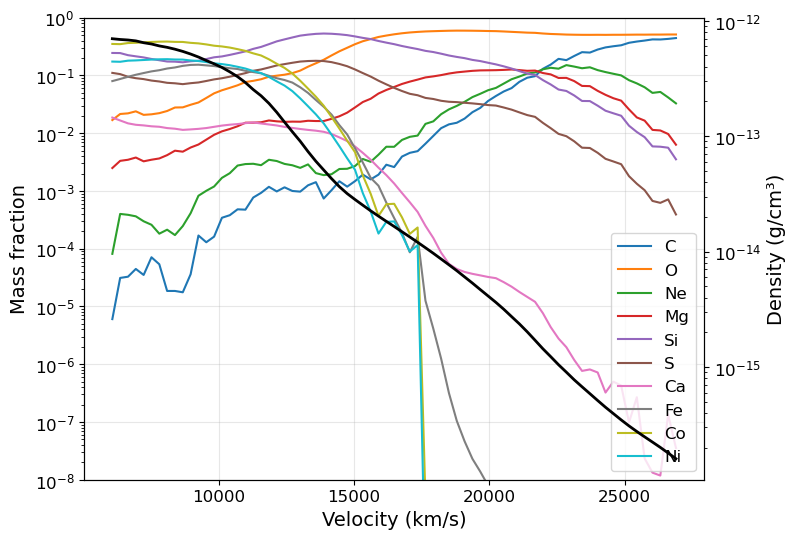

In [5]:
# Visualize the model structure
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

velocity = simulation_state.v_inner.to(u.km / u.s).value
element_names = [
    atomic_number2element_symbol(Z)
    for Z in simulation_state.composition.elemental_mass_fraction.index
]

# plot the abundance profiles first
for i, element_name in enumerate(element_names):
    ax.plot(
        velocity,
        simulation_state.composition.elemental_mass_fraction.iloc[i].values,
        label=element_name,
    )
ax.set_xlabel("Velocity (km/s)", fontsize=14)
ax.set_ylabel("Mass fraction", fontsize=14)
ax.legend(loc="lower right", fontsize=12, ncol=1)
ax.set_ylim(1e-8, 1e0)
ax.grid(alpha=0.3)

# plot the density profile at the secondary y-axis
ax_twin = ax.twinx()
time_explosion = simulation_state.time_explosion.to(u.day)
density = simulation_state.density.to(u.g / u.cm**3).value
ax_twin.plot(
    velocity,
    density,
    "k-",
    lw=2,
    label=f"Density (g/cm³) at t={time_explosion:.1f} day",
)
ax_twin.set_ylabel("Density (g/cm³)", fontsize=14)

for axs in [ax, ax_twin]:
    axs.tick_params(labelsize=12)
    axs.set_yscale("log")


### Compare the initial vs current profiles

The profiles you see above from the simulation state is already processed through time assuming the ejecta is expanding homologously, which includes the following:

- <u>**Density**</u>: In the assumption of homologous expansion, the radius ($r$) of the ejecta can be approximated with $r = v\times t$, hence the volume expansion scales with $t^{-3}$, which leads to the density scaling as $\rho(t) = \rho(t_0) (\frac{t}{t_0})^{-3}$.  
    - **The model initial density time is set by the `model_density_time_0` in the csvy file.** 
- <u>**Radiative isotope mass fractions**</u>: If the ejecta contains radioactive isotopes, TARDIS decays these isotopes from the model initial isotope time to the specified time since explosion. 
    - **The model initial isotope time is set by the `model_isotope_time_0` in the csvy file.** 

---

$\blacktriangleright$ TASK: Compare the initial and current profiles of:
- The density profile 
- The mass fraction of the iron group elements (Fe, Co, and Ni)

The original profiles can be accessed by reading in the csv part of the csvy file, eg: `pd.read_csv(file_path, skiprows=n)` where n is the number of lines before the the csv data part starts

In [6]:
df_original_profiles = pd.read_csv("configs_and_data/tardis_ddt_2013_n100_profile.csvy", skiprows=35)
df_original_profiles.head()

,velocity,density,Ni56,Co56,C,O,Ne,Mg,Si,S,Ca,Fe
0,6073.247214,0.452750,0.532263,0.000051,0.000001,0.012393,0.000025,0.001820,0.192210,0.092257,0.017973,0.052616
1,6362.449462,0.450970,0.491104,0.000054,0.000005,0.015240,0.000074,0.002252,0.221301,0.099977,0.016840,0.054865
2,6651.651710,0.444256,0.483833,0.000064,0.000028,0.019285,0.000359,0.002977,0.218845,0.094559,0.014896,0.060936
3,6940.853958,0.439705,0.501545,0.000073,0.000029,0.019619,0.000344,0.003084,0.199587,0.084378,0.013170,0.066672
4,7230.056207,0.431988,0.503087,0.000082,0.000039,0.021104,0.000321,0.003344,0.189220,0.079101,0.012342,0.073045


In [8]:
# reuse the code you wrote above to start with 
# your code here to overlay the initial and current profiles

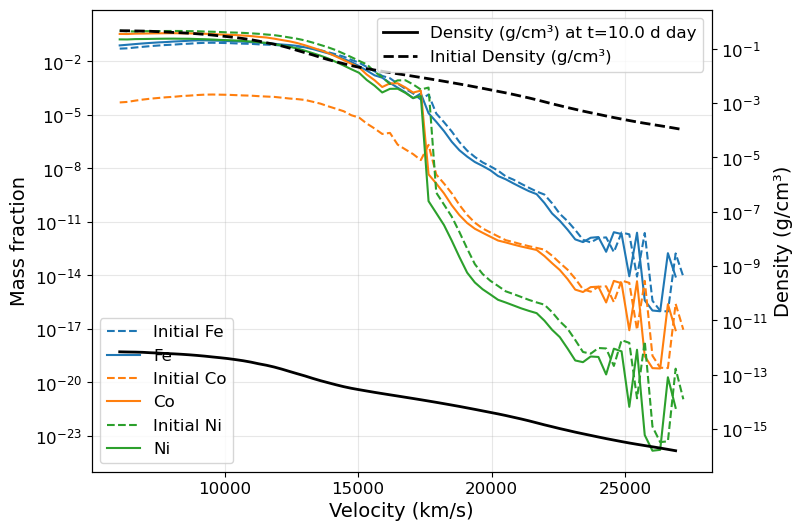

In [8]:
# Visualize the model structure
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

velocity = simulation_state.v_inner.to(u.km / u.s).value
element_names = [
    atomic_number2element_symbol(Z)
    for Z in simulation_state.composition.elemental_mass_fraction.index
]

## read in the initial profiles
profile_initial = pd.read_csv(
    "configs_and_data/tardis_ddt_2013_n100_profile.csvy", skiprows=35
)
IGE_elements = ["Fe", "Co", "Ni"]


# plot the abundance profiles first
for element in IGE_elements:
    isotopes = [col for col in profile_initial.columns if element in col]
    element_mass_fractions = profile_initial[isotopes].sum(axis=1)
    p = ax.plot(
        profile_initial["velocity"],
        element_mass_fractions,
        label=f"Initial {element}",
        linestyle="--",
    )
    element_index = element_names.index(element)
    ax.plot(
        velocity,
        simulation_state.composition.elemental_mass_fraction.iloc[
            element_index
        ].values,
        label=element,
        color=p[0].get_color(),
    )
ax.set_xlabel("Velocity (km/s)", fontsize=14)
ax.set_ylabel("Mass fraction", fontsize=14)
ax.legend(loc="lower left", fontsize=12, ncol=1)
ax.grid(alpha=0.3)

# plot the density profile at the secondary y-axis
ax_twin = ax.twinx()
time_explosion = simulation_state.time_explosion.to(u.day)
density = simulation_state.density.to(u.g / u.cm**3).value
ax_twin.plot(
    velocity,
    density,
    "k-",
    lw=2,
    label=f"Density (g/cm³) at t={time_explosion:.1f} day",
)
ax_twin.set_ylabel("Density (g/cm³)", fontsize=14)

ax_twin.plot(
    profile_initial["velocity"],
    profile_initial["density"],
    "k--",
    lw=2,
    label="Initial Density (g/cm³)",
)
ax_twin.legend(loc="upper right", fontsize=12)

for axs in [ax, ax_twin]:
    axs.tick_params(labelsize=12)
    axs.set_yscale("log")


# Set up the time and luminosity

While the initial ejecta profiles doesn't need to be changed, the time snapshot information including the time since explosion and the bolometric luminosity at that time should be updated for each TARDIS simulation. 

Let's pick 10 days past explosion as the time of interest as an example.

$\blacktriangleright$ Your task: Identify the luminosity at 10 days past explosion and update the information in the TARDIS config. 
- Identify the bolometric luminosity of given model at 10 days past explosion from the provided `ddt_2013_n100_lightcurve.dat`.
- Plot the bolometric luminosity as a function of time and verify the value you identified on the plot. 
- Update the `luminosity_requested` and `time_explosion` in the TARDIS config. 

<details>
<summary><strong>💡 <u>Click here for Hint</u> </strong></summary>
The interpolated bolometric luminosity at 10 day should be around 7.35e+42 erg/s. 
</details>



Text(0, 0.5, 'Bolometric Luminosity (erg/s)')

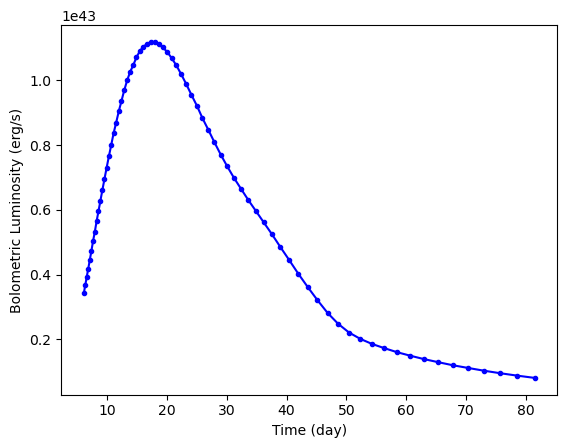

In [10]:
### Read in the bolometric luminosity light curve data and identify the luminosity at 10 days past explosion

## read the file
df_bolo_LC = pd.read_csv("configs_and_data/ddt_2013_n100_lightcurve.dat", sep=r"\s+")
df_bolo_LC
# plot the bolometric Light curve
plt.plot(
    df_bolo_LC["time[day]"],
    df_bolo_LC["bolometric_luminosity[erg/s]"],
    "b-",
    marker=".",
)
plt.xlabel("Time (day)")
plt.ylabel("Bolometric Luminosity (erg/s)")

## your code here to identify the luminosity at 10 days past explosion, 
## can use interpolation or simply read off the value from the most close time point
## and plot the point on the light curve to veri
# lum_10_day = ???

# print(f"Luminosity at 10 days: {lum_10_day:.2e} erg/s")

Luminosity at 10 days: 7.35e+42 erg/s


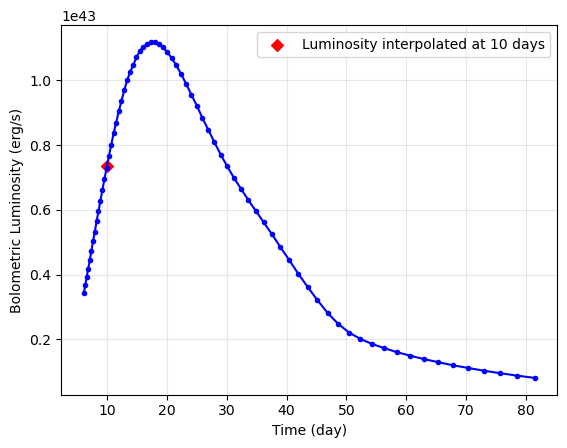

In [11]:
df_bolo_LC = pd.read_csv("configs_and_data/ddt_2013_n100_lightcurve.dat", sep=r"\s+")

# plot the bolometric luminosity
plt.plot(
    df_bolo_LC["time[day]"],
    df_bolo_LC["bolometric_luminosity[erg/s]"],
    "b-",
    marker=".",
)
plt.xlabel("Time (day)")
plt.ylabel("Bolometric Luminosity (erg/s)")

# intepolate the evaluate the bolometric luminosity at 10 days
lum_10_day = np.interp(
    10,
    df_bolo_LC["time[day]"],
    df_bolo_LC["bolometric_luminosity[erg/s]"],
)
plt.scatter(
    10, lum_10_day, marker="D", color="red", label="Luminosity interpolated at 10 days"
)
plt.grid(alpha=0.3)
plt.legend()

print(f"Luminosity at 10 days: {lum_10_day:.2e} erg/s")

 $\blacktriangleright$ Fill in the value in cell below to update the TARDIS config


In [10]:
config.supernova.time_explosion = 10 * u.day
config.supernova.luminosity_requested = ???? * u.erg / u.s

In [12]:
# update the time snapshot info in config
config.supernova.time_explosion = 10 * u.day
config.supernova.luminosity_requested = 7.35e42 * u.erg / u.s

# Photospheric Velocity Optimization

TARDIS currently relies on the photospheric assumption, where the energy source starts at the innermost boundary and is transported outward, with no additional energy input above this inner boundary. 

Thus it is important to set the optimal v_inner_boundary for a specific TARDIS simulation to ensure the synthetic spectrum is physically consistent. 

$\blacktriangleright$ Questions: Let's think about very extreme cases in TARDIS. What if:
- The inner boundary is set at a location with VERY LARGE optical depth?
- The inner boundary is set at a location with VERY SMALL optical depth?

Keep these thoughts in mind as we continue and verify your ideas along the way. 


<font size=+3>&#9998;</font> Double click this cell to write your answer here.

---

**How to find the optimal v_inner_boundary value in TARDIS?**

Each TARDIS simulation goes through an iterative process of:
- Initializing packets at the given v_inner_boundary, distributed as a (dilute) blackbody with temperature $T_{\text{inner}}$
- Transporting the packets through the ejecta and estimating radiation field properties (radiative temperature $T_{\text{rad}}$ and dilution factors $W$ in each shell)
- Updating the radiation field based on the estimators and convergence strategy, and updating $T_{\text{inner}}$ based on the ratio of requested luminosity to output luminosity, following the convergence strategy
- Calculating the plasma and opacity state based on the radiation field in each shell
- Repeating all above steps until the simulation converges 

<div style="background-color:rgb(95, 83, 77); border-left: 4px solid #f44336; padding: 10px; margin: 10px 0;">
<strong>Note:</strong> 
Even if the simulation converges, it doesn't necessarily mean the simulation results are physically consistent.
</div>

If the v_inner_boundary is set too deep compared to the true photosphere, then the dilution factor $W$ at the v_inner will be larger than 0.5, meaning that more than 50% of the energy is trapped within, and vice versa. 

----

We can use an iterative process to find the optimal location of v_inner_boundary.

Since our goal is to find a v_inner_boundary that has a dilution factor of 0.5, we can start a simulation run and nudge the v_inner_boundary inward/outward if the dilution factor $W$ at that location is too low/high.

Let's start with a relatively low value first and walk through the iterative process step by step to find the optimal v_inner_boundary.

---

## Iter1 - Run a simulation with the initial guess

$\blacktriangleright$ Run the cell below to run a TARDIS simulation with initial v_inner_boundary value (8097 km/s), which will take a couple minutes, monitor the dilution factor in the convergence plot. 

$\blacktriangleright$ While you are waiting the simulation to finish, think about what other properties can inform you which direction to nudge?

<div style="background-color:rgb(95, 83, 77); border-left: 4px solid #f44336; padding: 10px; margin: 10px 0;">
<strong> READ THIS:</strong> Keep each simulation named differently so that we can compare them later.
</div>

Optional: You can also check the rosseland mean optical depth: 
```python
from tardis.workflows.util import get_tau_integ
tau = get_tau_integ(
        sim.plasma,
        sim.opacity_state,
        sim.simulation_state,
    )["rosseland"].to(1)
```

In [33]:
### this is a guard for the correct v_inner_boundary value
v_inner_boundary = 8097.66
df_csvy_data = pd.read_csv("configs_and_data/tardis_ddt_2013_n100_profile.csvy", skiprows=35)
assert np.isclose( df_csvy_data["velocity"].values[0].round(2), v_inner_boundary, atol=1e-3), f"Looks like you have not the csvy file yet to adjust the v_inner_boundary, \n please remove/add rows to make sure the first shells starts at {v_inner_boundary:2f} km/s."


### keep each simulation named differently so that we can compare them later
sim_iter1 = run_tardis(
    config,
    virtual_packet_logging=True,
    show_convergence_plots=True,
    export_convergence_plots=True
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'afedb22f-e6a1-4240-b105-04f7196c581b': {'version…

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

    'data': [{'type': 'scatter', 'uid': 'f746aa23-3406-45c0-8d06-f54dbc14b1c5', …

    'data': [{'type': 'scatter', 'uid': 'f746aa23-3406-45c0-8d06-f54dbc14b1c5', …

$\blacktriangleright$ Did the simulation converge? Does the dilution factor make sense? How about $T_{\text{inner}}$?

**Congratulations! You just witnessed an unphysical TARDIS simulation!**

If the v_inner_boundary is located too deep where optical depth is too high, relatively few packets will escape, resulting in low output luminosity. To compensate, the convergence solver in TARDIS will increase $T_{\text{inner}}$ to increase the output energy, but the radiation field condition may no longer be suitable for the physical assumptions in TARDIS.

---- 

The dilution factor should be within the range of (0,1) in normal settings. If the simulation has a dilution factor outside this range, then the results are NOT physical and should NOT be trusted.

In the simulation above, the dilution factors are >> 1, which corresponds to a radiation field that no longer follows the blackbody distribution and will provide a false mean intensity estimation.

Recall from Day 3, TARDIS uses the `j_blue_estimator` to bridge between the Monte Carlo packets and plasma state to gain information about the radiation field.

$\blacktriangleright$ Run the cell below to see the `j_blue_estimator` vs atomic line wavelength in shell indices [0, 4, 39], labeling each shell with the corresponding dilution factor.

Notice that in shells with a dilution factor outside the range of (0,1), the `j_blue_estimator` does NOT follow a blackbody distribution.

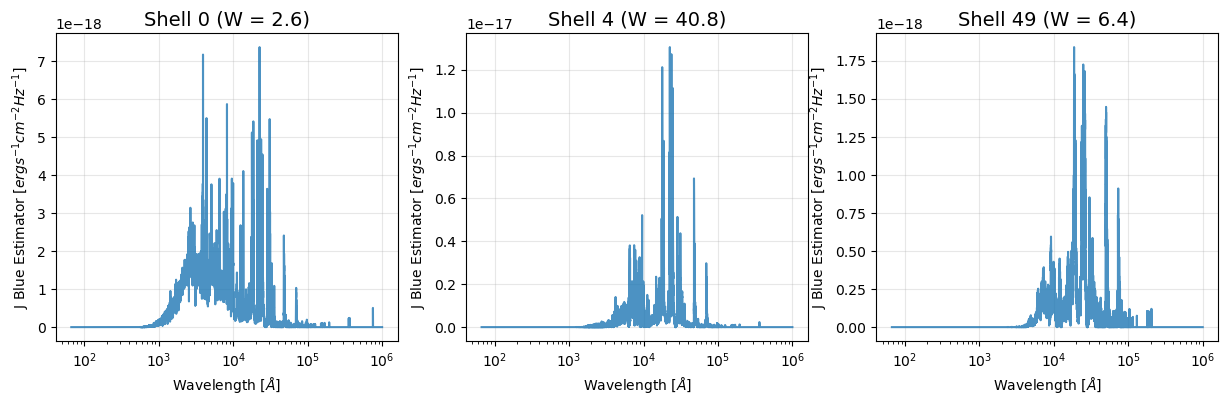

In [61]:
sim = sim_iter1
fig, axes = plt.subplots(1,3, figsize=(15, 4))
shell_index_s = [0,4,49]
for i, shell_index in enumerate(shell_index_s):
    ax = axes[i]
    j_estimator = sim.transport.transport_state.j_blue_estimator[:,shell_index]
    ax.plot(
        sim.plasma.atomic_data.lines.wavelength,
        j_estimator,
        alpha = 0.8
    )
    ax.set_title(f"Shell {shell_index} (W = {sim.simulation_state.dilution_factor[shell_index]:.1f})", fontsize=14)
    ax.grid(alpha=0.3)
    ax.set_xscale('log')
    ax.set_xlabel(r'Wavelength [$\AA$]')
    ax.set_ylabel(r'J Blue Estimator [$erg s^{-1} cm^{-2} Hz^{-1}$]')




## Iter2 - Iterate to Find Optimal v_inner_boundary

The above iteration shows too high of a dilution factor. Let's move the v_inner_boundary outwards with the hope of reducing the dilution factor!

$\blacktriangleright$ Increase the v_inner_boundary to 10122 km/s and run another simulation.

<div style="background-color:rgb(95, 83, 77); border-left: 4px solid #f44336; padding: 10px; margin: 10px 0;">
<strong>READ THIS:</strong> Due to a recent refactor of the code, the v_inner_boundary setting in the csvy model is not available at the moment (will be fixed soon), so you will have to modify the file manually <strong>for now</strong> to change it. Only keep the shells starting from the intended v_inner_boundary in the csv part of the csvy file. For your convenience, a `tardis_ddt_2013_n100_profile_original.csvy` file is provided if you need to add back inner layers.
</div>

For this next iteration with v_inner_boundary = 10122 km/s, **modify the csvy file** (delete the data rows with velocity values smaller than 10122).


In [18]:
v_inner_boundary = 10122.08
df_csvy_data = pd.read_csv("configs_and_data/tardis_ddt_2013_n100_profile.csvy", skiprows=35)
assert np.isclose( df_csvy_data["velocity"].values[0].round(2), v_inner_boundary, atol=1e-3), f"Looks like you have not the csvy file yet to adjust the v_inner_boundary, \n please remove/add rows to make sure the first shells starts at {v_inner_boundary:2f} km/s."

sim_iter2 = run_tardis(
    config,
    model = simulation_state,
    virtual_packet_logging=True,
    show_convergence_plots=True,
    export_convergence_plots=True,
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'8d548eef-1025-4de4-980c-236cf12eb154': {'version…

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

    'data': [{'type': 'scatter', 'uid': '9f28844b-7bc4-437c-abcc-c24c387cdefc', …

    'data': [{'type': 'scatter', 'uid': '9f28844b-7bc4-437c-abcc-c24c387cdefc', …

## Iter3 - Iterate to Find Optimal v_inner_boundary

$\blacktriangleright$ Did the simulation converge? Does the dilution factor make sense? How does it compare to the previous run?

The dilution factors still seem to be in a region of unphysical parameter space, but the value is decreasing as we hoped.

$\blacktriangleright$ Increase the v_inner_boundary out to 15038 km/s and run another simulation. 

In [4]:
v_inner_boundary = 15038.52
df_csvy_data = pd.read_csv("configs_and_data/tardis_ddt_2013_n100_profile.csvy", skiprows=35)
assert np.isclose( df_csvy_data["velocity"].values[0].round(2), v_inner_boundary, atol=1e-3), f"Looks like you have not the csvy file yet to adjust the v_inner_boundary, \n please remove/add rows to make sure the first shells starts at {v_inner_boundary:2f} km/s."

sim_iter3 = run_tardis(
    config,
    virtual_packet_logging=True,
    show_convergence_plots=True,
    export_convergence_plots=True,
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'9b7e71d4-343c-4fee-b96e-30359b186eb8': {'version…

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

    'data': [{'type': 'scatter', 'uid': '332c7f37-c1fb-404b-af47-10c2e9148d8e', …

    'data': [{'type': 'scatter', 'uid': '332c7f37-c1fb-404b-af47-10c2e9148d8e', …

You have done it! Now the dilution factor is within the physical range (0,1)!

## Iter4 - Iterate to Find Optimal v_inner_boundary

Since now the dilution factor is smaller than the target value (0.5), let's nudge it in the other direction.

$\blacktriangleright$ Run another simulation with v_inner_boundary of 13014 km/s. **Modify the csvy file** (add the data rows with velocity values between 13014.10 and 15038 km/s from the `tardis_ddt_2013_n100_profile_original.csvy` file.)


In [19]:
v_inner_boundary = 13014.10
df_csvy_data = pd.read_csv("configs_and_data/tardis_ddt_2013_n100_profile.csvy", skiprows=35)
assert np.isclose( df_csvy_data["velocity"].values[0].round(2), v_inner_boundary, atol=1e-3), f"Looks like you have not the csvy file yet to adjust the v_inner_boundary, \n please remove/add rows to make sure the first shells starts at {v_inner_boundary:2f} km/s."

sim_iter4 = run_tardis(
    config,
    virtual_packet_logging=True,
    show_convergence_plots=True,
    export_convergence_plots=True,
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'47c3c51d-4955-445f-abca-882928f94ad4': {'version…

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

    'data': [{'type': 'scatter', 'uid': 'fe0f0448-e892-4c26-bd41-d60d9058e58f', …

    'data': [{'type': 'scatter', 'uid': 'fe0f0448-e892-4c26-bd41-d60d9058e58f', …

Congratulations! You are very close! Let's check how close we are, and in an iterative process, it is good practice to do at least one more iteration when you think you have found the optimal solution, to confirm that the answer you found is stable.

Before we do that, let's plot the dilution factor vs velocity of all the simulations run so far to provide evidence for a better educated guess. 

$\blacktriangleright$ Plot the dilution factors vs velocity of each simulation, and mark the target value W = 0.5 as well.

In [ ]:
# ### uncomment this cell and fill in the comparison code here
# fig,ax = plt.subplots(1, 1, figsize=(8, 6))

# for i, sim in enumerate([sim_iter1, sim_iter2, sim_iter3, sim_iter4]):
#     velocity = ???
#     dilution_factor = ???
#     ax.plot(
#         velocity,
#         dilution_factor,
#         label=f"v_inner_boundary={sim.simulation_state.v_inner_boundary.to(u.km/u.s).value:.2f} km/s, W={dilution_factor[0]:.2f}",
#     )

# ### Mark the target dilution factor W = 0.5
# ax.???

# ax.set_yscale("log")
# ax.set_xlabel("Velocity (km/s)", fontsize=14)
# ax.set_ylabel("Dilution Factor", fontsize=14)
# ax.legend(loc="upper right", fontsize=12, ncol=1)
# ax.grid(alpha=0.3)  

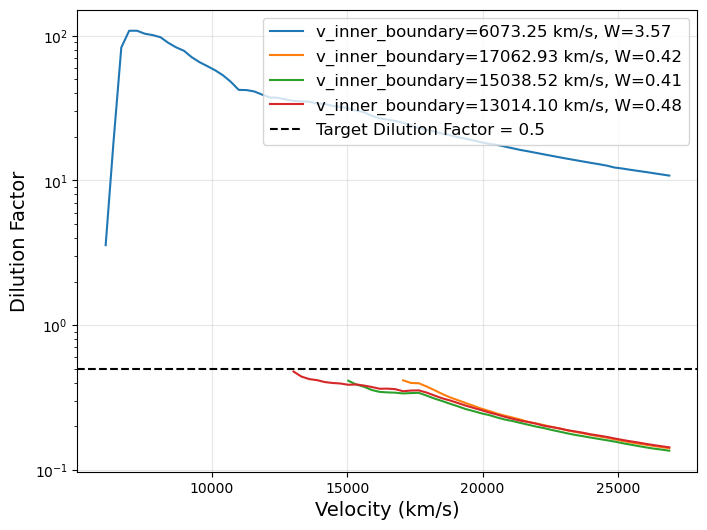

In [31]:
fig,ax = plt.subplots(1, 1, figsize=(8, 6))

for i, sim in enumerate([sim_iter1, sim_iter2, sim_iter3, sim_iter4]):
    velocity = sim.simulation_state.v_inner.to(u.km / u.s).value
    dilution_factor = sim.simulation_state.dilution_factor
    ax.plot(
        velocity,
        dilution_factor,
        label=f"v_inner_boundary={sim.simulation_state.v_inner_boundary.to(u.km/u.s).value:.2f} km/s, W={dilution_factor[0]:.2f}",
    )
ax.axhline(
    0.5,
    color="k",
    linestyle="--",
    label="Target Dilution Factor = 0.5",
)
ax.set_yscale("log")
ax.set_xlabel("Velocity (km/s)", fontsize=14)
ax.set_ylabel("Dilution Factor", fontsize=14)
ax.legend(loc="upper right", fontsize=12, ncol=1)
ax.grid(alpha=0.3)  

## Iter5 - Iterate to Find Optimal v_inner_boundary

The last simulation has a dilution factor of 0.48 in the first shell, which is slightly smaller than 0.5. Let's nudge it two shells further in this time.

$\blacktriangleright$ Run another simulation with v_inner_boundary of 12435 km/s. (Add back 2 rows in the csvy file)


In [10]:
v_inner_boundary = 12435.69
df_csvy_data = pd.read_csv("configs_and_data/tardis_ddt_2013_n100_profile.csvy", skiprows=35)
assert np.isclose( df_csvy_data["velocity"].values[0].round(2), v_inner_boundary, atol=1e-3), f"Looks like you have not the csvy file yet to adjust the v_inner_boundary, \n please remove/add rows to make sure the first shells starts at {v_inner_boundary:2f} km/s."

sim_iter5 = run_tardis(
    config,
    virtual_packet_logging=True,
    show_convergence_plots=True,
    export_convergence_plots=True,
)

print(f"Iteration 5 Dilution Factor: {sim_iter5.simulation_state.dilution_factor[0]}")

BokehModel(combine_events=True, render_bundle={'docs_json': {'49901775-0561-4730-8641-fa76bfde1e57': {'version…

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

    'data': [{'type': 'scatter', 'uid': '7a892bc7-1d92-4dc2-906c-df5200d0f583', …

    'data': [{'type': 'scatter', 'uid': '7a892bc7-1d92-4dc2-906c-df5200d0f583', …

Iteration 5 Dilution Factor: 0.4856865789948078


# Analyze the spectrum

Congratulations! You found the optimal v_inner_boundary value through an iterative process!

$\blacktriangleright$ Looking at the radiative temperature and dilution factor in the convergence plot, did you notice something interesting?

<details>
<summary><strong>💡 <u>Click here for Hint</u> </strong></summary>
Both the radiative temperature and dilution factor show a slope change at a location around 17,500 km/s.
</details>

---

Let's try to figure this out. What's the physical reason behind this?

First, take a look at the spectrum and the ion contribution using the visualization tools we learned in the previous notebook, and also think about the underlying properties of the radiation field and plasma state.

$\blacktriangleright$ Use SDEC plot to visualize the ion contribution (see the previous notebook on how to plot the SDEC plot). 

In [4]:
### your code here

# sim = sim_iter5
# plotter = ???

<Axes: xlabel='$\\text{Wavelength}\\,[\\mathrm{\\mathring{A}}]$', ylabel='$L_{\\lambda}\\,[\\mathrm{erg\\,s^{-1}\\,\\mathring{A}^{-1}}]$'>

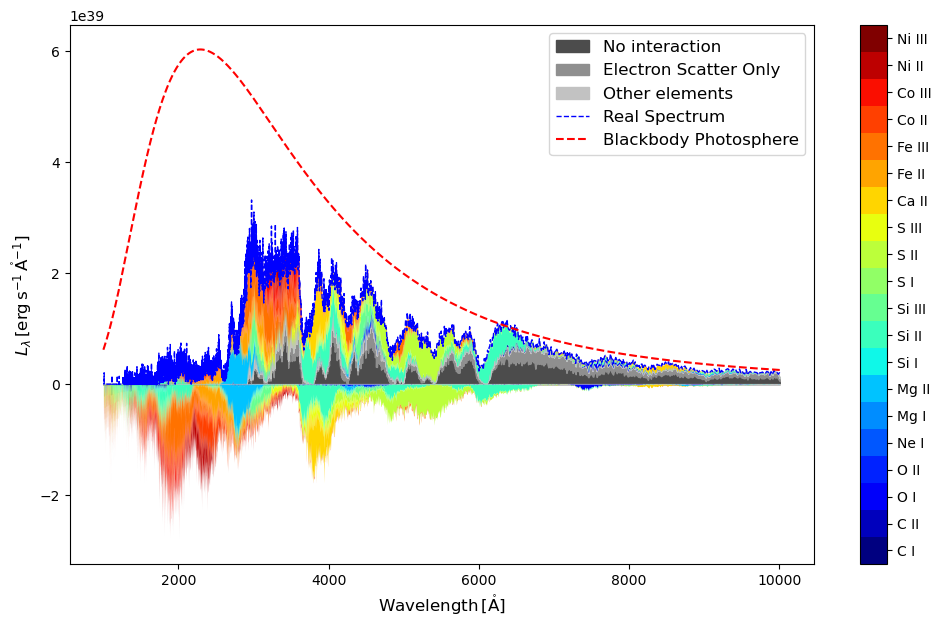

In [35]:
sim = sim_iter5

# plot the SDEC plot
plotter = SDECPlotter.from_simulation(sim)
plotter.generate_plot_mpl(
    packets_mode="real",
    packet_wvl_range=[1000, 10000] * u.AA,
    species_list=["C I-III", "O I-III","Ne I-III", "Mg I-III", "S I-III", "Si I-III", "Ca I-III", "Fe I-III", "Co I-III", "Ni I-III"],
)

$\blacktriangleright$ What are the dominating ions in this spectrum? Are they representative of observed Type Ia supernovae (which are usually dominated by iron-group element line opacity in the UV, and intermediate-mass elements such as S, Si, Ca, and Mg in the optical region)?

----

$\blacktriangleright$ Run the next code cell to Zoom in on the [7740, 8600] $\AA$ region (using virtual packets) where the Ca II NIR triplets feature is, and is it purely Ca II? If not what are the other ions that also contribute to this feature? 

----

The feature is dominated by Ca II but also has contribution from other irons such as Mg II and Si III, this is a perfect sample of how SDEC can be used to decompose the ion contribution in blended regions.


[py.warnings         ][WARNING]  /Users/jing/Software/tardis/tardis/visualization/tools/sdec_plot.py:333: RuntimeWarning:

The values in the array are unorderable. Pass `sort=False` to suppress this warning.

 (warnings.py:110)
[py.warnings         ][WARNING]  /Users/jing/Software/tardis/tardis/visualization/tools/sdec_plot.py:333: RuntimeWarning:

The values in the array are unorderable. Pass `sort=False` to suppress this warning.

 (warnings.py:110)
[tardis.visualization.tools.sdec_plot][INFO   ]  OII is not in the absorbed packets; skipping (sdec_plot.py:1343)
[tardis.visualization.tools.sdec_plot][INFO   ]  SI is not in the absorbed packets; skipping (sdec_plot.py:1343)


,Fraction of packets interacting
Species,
Ca II,0.243893
Si III,0.225191
O I,0.174046
S II,0.121756
Si II,0.088550
Mg II,0.051908
Ni II,0.036641
Co II,0.016794
Fe III,0.014885


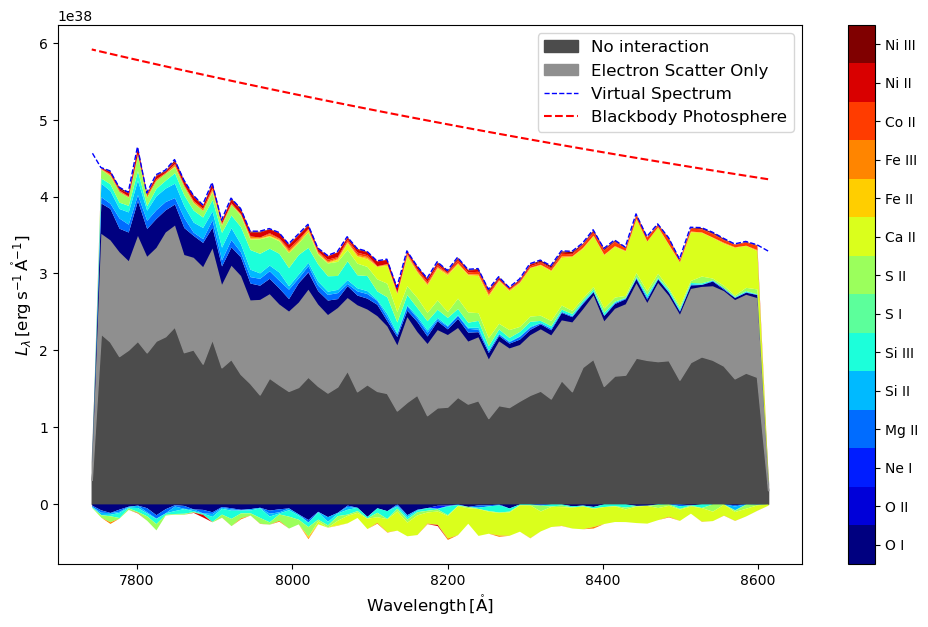

In [20]:
sim = sim_iter5
wavelength_range = [7740, 8600]

# plot the SDEC plot
plotter = SDECPlotter.from_simulation(sim)
plotter.generate_plot_mpl(
    packets_mode="virtual",
    packet_wvl_range=wavelength_range * u.AA,
    species_list=["C I-III", "O I-III","Ne I-III", "Mg I-III", "S I-III", "Si I-III", "Ca I-III", "Fe I-III", "Co I-III", "Ni I-III"],
)

# using the LineInfoWidget data to see which ions are the dominant contributors to the spectrum
line_info_widget = LineInfoWidget.from_simulation(sim)
display(
    line_info_widget.get_species_interactions(
        wavelength_range=wavelength_range, filter_mode="packet_out_nu"
    )
)


---

Let's continue the investigation of the line formation region and the corresponding ejecta properties of the shells. We will plot the following information:

- A Line Interaction Velocity plot using the LIVplotter
- The mass fraction and density profile as a function of shell velocity
- The radiative temperature and dilution factor as a function of shell velocity

$\blacktriangleright$ Uncomment the cell below and fill in the values in the code cell below to finish the comparison plot.

In [ ]:
# ## define a figure with 3 subplots that shares the same x-axis
# fig, axes = plt.subplots(3, 1, figsize=(8, 12),sharex=True)
# #### plot the LIV plot in axes[0]
# sim = sim_iter5
# liv_plotter = LIVPlotter.from_simulation(sim)
# liv_plotter.generate_plot_mpl(
#     packets_mode="real",
#     ylog_scale=True,
#     ax = axes[0],
# )
# ymin,ymax = axes[0].get_ylim()
# axes[0].set_ylim(1e1, ymax)

# #### extract the elements plotted in the LIV plot and their colors from the legend
# handles, element_labels = liv_plotter.ax.get_legend_handles_labels()
# element_plot_colors = [handle.get_color() for handle in handles]    
# element_atomic_numbers = [element_symbol2atomic_number(element) for element in element_labels]

# #### plot the mass fraction of the elements vs shell velocities in axes[1]
# for i, element_atomic_number in enumerate(element_atomic_numbers):
#     axes[1].plot(
#         ???,
#         ???,
#         label=element_labels[i],
#         color=element_plot_colors[i],
#     )
# axes[1].set_xlabel("Velocity (km/s)", fontsize=14)
# axes[1].set_ylabel("Mass fraction", fontsize=14)
# axes[1].set_yscale("log")
# axes[1].set_ylim(1e-7, 1e0)

# #### plot the density profile vs velocity in axes[1].twinx()
# ax_twin = axes[1].twinx()
# ax_twin.plot(
#     ???,
#     ???,
#     "k--",
#     lw=2,
#     label=f"Density (g/cm³) at t={sim.simulation_state.time_explosion.to(u.day):.0f} day",
# )
# ax_twin.set_ylabel(f"Density (g/cm³) at t={sim.simulation_state.time_explosion.to(u.day):.0f} day", fontsize=14)
# ax_twin.legend(loc="upper right", fontsize=12, ncol=1)

# #### plot the T_rad vs velocity
# axes[2].plot(
#     ???,
#     ???,
#     "r-",
#     lw=2,
#     label="Radiative Temperature",
# )
# axes[2].set_xlabel("Velocity (km/s)", fontsize=14)
# axes[2].set_ylabel("Radiative Temperature (K)", fontsize=14)
# axes[2].legend(loc="upper left", fontsize=12, ncol=1)
# #### plot the dilution factor vs velocity
# axes_twin2 = axes[2].twinx()
# axes_twin2.plot(
#     ???,
#     ???,
#     "b--",
#     lw=2,
#     label=f"Dilution Factor",
# )
# axes_twin2.legend(loc="upper right", fontsize=12, ncol=1)
# axes_twin2.set_ylabel(f"Dilution Factor W", fontsize=14,color="b")

# for ax in axes:
#     ax.grid(alpha=0.3)
#     ax.tick_params(labelsize=12, labelbottom=True)


[(12, 1), (27, 1), (14, 1), (8, 0), (10, 0), (26, 2), (16, 1), (12, 0), (20, 1), (14, 0), (14, 3), (28, 2), (27, 3), (8, 2), (26, 1), (16, 0), (6, 1), (16, 3), (14, 2), (27, 2), (28, 1), (8, 1), (16, 2), (26, 3), (6, 0)] [(6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5)]
[(12, 1), (27, 1), (14, 1), (8, 0), (10, 0), (26, 2), (16, 1), (12, 0), (20, 1), (14, 0), (14, 3), (28, 2), (27, 3), (8, 2), (26, 1), (16, 0), (6, 1), (16, 3), (14, 2), (27, 2), (28, 1), (8, 1), (16, 2), (26, 3), (6, 0)] [(8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7)]
[(12, 1), (27, 1), (14, 1), (8, 0), (10, 0), (26, 2), (16, 1), (12, 0), (20, 1), (14, 0), (14, 3), (28, 2), (27, 3), (8, 2), (26, 1), (16, 0), (6, 1), (16, 3), (14, 2), (27, 2), (28, 1), (8, 1), (16, 2), (26, 3), (6, 0)] [(10, 0), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (10, 7), (10, 8), (10, 9)]
[(12, 1), (27, 1), (14, 1), (8, 0), (10, 0), (26, 2), (16, 1), (12, 0), (20, 1), (14, 0), (14, 3), (28, 2), (27, 3), (8, 2), (26, 1)

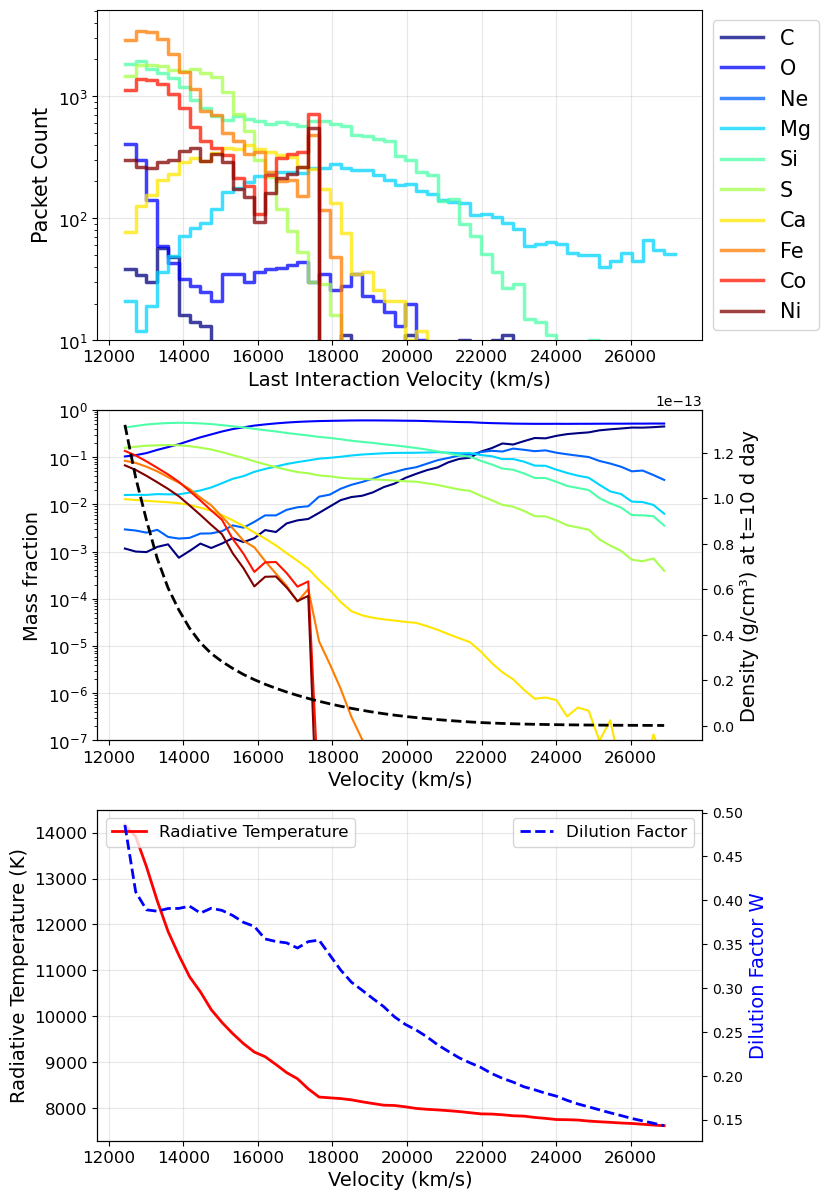

In [28]:
## define a figure with 3 subplots that shares the same x-axis
fig, axes = plt.subplots(3, 1, figsize=(8, 12),sharex=True)
#### plot the LIV plot in axes[0]
sim = sim_iter5
liv_plotter = LIVPlotter.from_simulation(sim)
liv_plotter.generate_plot_mpl(
    packets_mode="real",
    ylog_scale=True,
    ax = axes[0],
)
ymin,ymax = axes[0].get_ylim()
axes[0].set_ylim(1e1, ymax)

#### extract the elements plotted in the LIV plot and their colors from the legend
handles, element_labels = liv_plotter.ax.get_legend_handles_labels()
element_plot_colors = [handle.get_color() for handle in handles]    
element_atomic_numbers = [element_symbol2atomic_number(element) for element in element_labels]

#### plot the mass fraction of the elements in axes[1]
for i, element_atomic_number in enumerate(element_atomic_numbers):
    axes[1].plot(
        sim.simulation_state.v_inner.to(u.km / u.s).value,
        sim.simulation_state.composition.elemental_mass_fraction.loc[element_atomic_number].values,
        label=element_labels[i],
        color=element_plot_colors[i],
    )
axes[1].set_xlabel("Velocity (km/s)", fontsize=14)
axes[1].set_ylabel("Mass fraction", fontsize=14)
axes[1].set_yscale("log")
axes[1].set_ylim(1e-7, 1e0)

#### plot the density profile in axes[1].twinx()
ax_twin = axes[1].twinx()
ax_twin.plot(
    sim.simulation_state.v_inner.to(u.km / u.s).value,
    sim.simulation_state.density.to(u.g / u.cm**3).value,
    "k--",
    lw=2,
    label=f"Density (g/cm³) at t={sim.simulation_state.time_explosion.to(u.day):.0f} day",
)
ax_twin.set_ylabel(f"Density (g/cm³) at t={sim.simulation_state.time_explosion.to(u.day):.0f} day", fontsize=14)
ax_twin.legend(loc="upper right", fontsize=12, ncol=1)

#### plot the T_rad and W
axes[2].plot(
    sim.simulation_state.v_inner.to(u.km / u.s).value,
    sim.simulation_state.t_radiative.to(u.K).value,
    "r-",
    lw=2,
    label="Radiative Temperature",
)
axes[2].set_xlabel("Velocity (km/s)", fontsize=14)
axes[2].set_ylabel("Radiative Temperature (K)", fontsize=14)
axes[2].legend(loc="upper left", fontsize=12, ncol=1)

axes_twin2 = axes[2].twinx()
axes_twin2.plot(
    sim.simulation_state.v_inner.to(u.km / u.s).value,
    sim.simulation_state.dilution_factor,
    "b--",
    lw=2,
    label=f"Dilution Factor",
)
axes_twin2.legend(loc="upper right", fontsize=12, ncol=1)
axes_twin2.set_ylabel(f"Dilution Factor W", fontsize=14,color="b")

for ax in axes:
    ax.grid(alpha=0.3)
    ax.tick_params(labelsize=12, labelbottom=True)


From the above comparison of the last line interaction velocity, mass fraction, density, and dilution factor, let's think about the concepts we have learned in the past 3 days.

$\blacktriangleright$ Question 1: Computationally in TARDIS, what affects the quantity of interaction between an energy packet and ions (represented in a macroatom)?

$\blacktriangleright$ Question 2: How does TARDIS estimate the radiation field after the transport state?

$\blacktriangleright$ Question 3: From the plot above, what caused the slope change in the radiative temperature and dilution factor, and why? 

---
<details>
<summary><strong>💡 <u> Click here for Hint 1</u> </strong></summary>
The line interaction event is determined by the <strong>Sobolev optical depth</strong> (recall from Day 1 slides and Day 2 plasma introduction notebook), which depends on the wavelength-dependent cross section, level number density and the time since explosions. The cross section is based on the atomic data, and the ionization/level populations depend on the <strong>radiative temperature</strong>.
</details>

<br>

<details>
<summary><strong>💡 <u> Click here for Hint 2</u> </strong></summary>
TARDIS uses estimators (recall from Day 3 afternoon) to collect information from the packets that transport through the plasma, and obtains the mean intensity and mean frequency estimators to estimate the radiative temperature and dilution factor, <a href="https://tardis-sn.github.io/tardis/physics/update_and_conv/update_and_conv.html#T_\mathrm{rad}-and-W">see more details in this documentation page</a>
</details>

<br>

<details>
<summary><strong>💡 <u> Click here for Hint 3</u> </strong></summary>
It seems to be strongly correlated with the mass fraction of the iron-group elements, which affects the balance of the plasma state, hence the radiation field.
</details>

---
# Summary

This notebook demonstrates the process of producing synthetic spectra for hydrodynamic explosion models using TARDIS, focusing on a delayed detonation Type Ia supernova model from [Heidelberg Supernova Model Archive (HESMA, see reference within)](https://old-hesma.h-its.org/doku.php?id=data:models:ddt_2013_n100_overview).

**Key Physical Concepts**

**Homologous Expansion**: During the photospheric phase, supernova ejecta undergo homologous expansion where $\rho(t) = \rho(t_0) \left(\frac{t}{t_0}\right)^{-3}$ while maintaining velocity structure. This enables time-series modeling from a single hydrodynamic snapshot by scaling density and evolving radioactive isotopes.

**Photospheric Boundary Determination**: The critical challenge lies in identifying the optimal $v_{\text{inner}}$ boundary representing the photosphere ($\tau \approx 2/3$). TARDIS uses the dilution factor criterion $W = 0.5$, where $W$ represents the fraction of energy escaping.


**Tips for using TARDIS for post-processing hydro models**

---

# Optional Explorations

If you have more free time and feel comfortable, you can continue exploring TARDIS for the purpose of post-processing hydro simulation outcomes! Here are some suggestions:

- Pick another time snapshot and repeat this workflow: go back to the step "Set up the time and luminosity" to pick another time snapshot, and repeat the workflow to produce another spectrum. Compare the spectrum at t = 10 days past explosion and analyze the differences and reasons behind them. 

or 

- Process a time snapshot of a hydro model that you are interested in, first make sure the model is in homologous expansion and then parse the ejecta model into a csvy file. Start a new yml for this model and try repeat the workflow in this notebook. 



In [4]:
from IPython import get_ipython
from pathlib import Path
ip = get_ipython()
path = None
if '__vsc_ipynb_file__' in ip.user_ns:
    path = ip.user_ns['__vsc_ipynb_file__']
    
nb_path = Path(path)
# Get the current notebook name
current_notebook = nb_path.name

# Create the student version by replacing 'instructor' with 'student'
output_notebook = current_notebook.replace('instructor', 'student')

# Run the nbconvert command
!jupyter nbconvert {current_notebook} --ClearOutputPreprocessor.enabled=True --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags="['solution']" --to notebook --output {output_notebook}

print(f"Converted {current_notebook} to {output_notebook}")

/Users/jing/mambaforge/bin/jupyter-nbconvert:6: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  from nbconvert.nbconvertapp import main
[NbConvertApp] Converting notebook 2_postprocessing_hydromodel_instructor.ipynb to notebook
[NbConvertApp] Writing 38763 bytes to 2_postprocessing_hydromodel_student.ipynb
Converted 2_postprocessing_hydromodel_instructor.ipynb to 2_postprocessing_hydromodel_student.ipynb
